# Using FastChem2 to calculate the chemical abundances

Using FastChem 2.0 (https://github.com/exoclime/FastChem, the updated version of Stock et al. 2018), we can calculate the abundance of various chemical species assuming chemical equilibrium with 1D temperature-pressure atmospheric profile

In [1]:
import numpy as np
import astropy.constants as const
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Temperature-pressure profile 

First, define the physical parameters of the exoplanet that we want to model, in this case we assume the planet is WASP-33b (Collier Cameron e al. 2010)

In [2]:
#Input parameter
#Example for wasp33b

Mp   = 3.266  #Planetary mass in Jupiter mass
Rp   = 1.679  #Planetary radius in Jupiter radius
T_irr= 3100.0 #Temperature equivalence of the irradiation in Kelvin
T_int= 100.   #temperature equivalence of the intrinsic energy flow in Kelvin
g    = const.G.value*Mp* const.M_jup.value/(Rp*const.R_jup.value)**2*100. # cm/s2


Then, we calculate the 1D atmospheric temperature-pressure profile using equation 29 in Guillot (2010). We divide our atmosphere into 70 layers from the pressure of 100 bar to 1e-8 bar.

In [3]:
#Pressure array for each layer boundaries in bar
plist= jnp.logspace(2,-8,70)

We then also assume the mean infrared opacity (k_th) of 0.01 cm2 g-1 (if H- is the dominant source of spectral continuum, Arcangeli et al. 2018) and the ratio of optical and IR opacity (kappa_v/kappa_th or gamma) of 2. Gamma > 1 means inverted atmosphere (increasing temperature with altitude), while gamma < 1 means non-inverted atmosphere

In [4]:
k_th= 0.01 
gamma= 2

In the equation 29 in Guillot (2010), there is a f parameter that we need to define. f = 1 for the substellar point, f = 1/2 for a day-side average and f = 1/4 for an averaging over the whole planetary surface. Let's assume f= 1 for now

In [5]:
f=1

Now, let's calculate the temperature array based on the above parameters

In [6]:
#Temperature array calculated using Guillot (2010) equation (29)
from exojax.atm.atmprof import atmprof_Guillot
tlist=atmprof_Guillot(plist,g,k_th,gamma,T_int,T_irr,f)

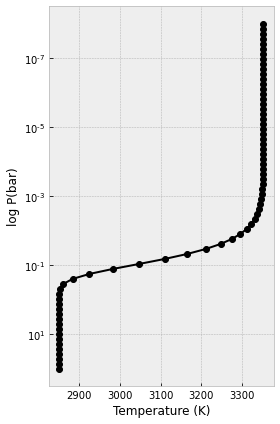

In [7]:
plt.figure(figsize=(4,6))
plt.plot(tlist,plist,'ko-')
plt.xlabel("Temperature (K)")
plt.ylabel("log P(bar)")
plt.yscale("log")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Chemical abundances

Define the directory of your FastChem, for now assume it is in /mnt/phoe/PlanetSpecGen/FastChem/

In [8]:
dir_fastchem='/mnt/phoe/PlanetSpecGen/FastChem/'

Now, we input our temperature-pressure profile (tlist, plist) to the FastChem

In [9]:
import pyfastchem
from exojax.atm.fastchem2_call import TP_profile_input, run_fastchem

#Inputting T-P profile to FastChem
input_data, output_data= TP_profile_input(plist,tlist)

Input also the chemical abundances and thermochemical data for all molecules and ions at solar metalicity and C/O

In [10]:
fastchem = pyfastchem.FastChem(str(dir_fastchem)+"input/element_abundances_solar_ext.dat",
                               str(dir_fastchem)+"input/logK_ext.dat", 1)

If it is needed, you can also change the C/O ratio to your preferred value. This is done by setting the O abundance as a function of the C/O ratio (Molliére et al. 2015)

In [11]:
#C/O= 0.5495408738576247 -> solar C/O
from exojax.atm.fastchem2_call import set_C_to_O
set_C_to_O(fastchem, 0.5495408738576247)

C/O is set to 0.5495408738576247


Or even change the metallicity ([M/H] or [Fe/H]) as well. This is done by scaling all of the chemical species but H and He for [M/H] or only Fe for [Fe/H]

In [12]:
#[M/H]= 0, [Fe/H]=0 -> solar
from exojax.atm.fastchem2_call import set_Fe_to_H
set_Fe_to_H(fastchem, 0)

[Fe/H] is set to 0


Finally, now let's run the FastChem 2.0

In [13]:
mixing_ratios=run_fastchem(fastchem, input_data, output_data)

FastChem reports: convergence ok


Plot several important molecular species

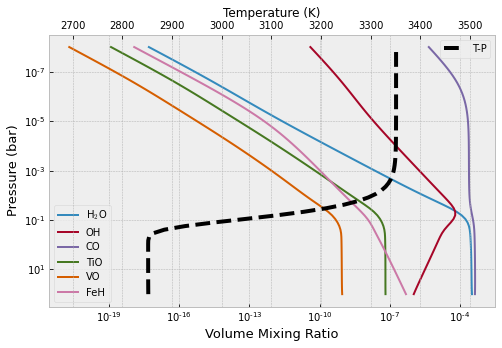

<Figure size 432x288 with 0 Axes>

In [14]:
from exojax.atm.fastchem2_call import vmr_species_fc2

species_name=np.array(["H2O1","H1O1","C1O1","O1Ti1","O1V1","Fe1H1"])
species_label=np.array(["H$_{2}$O","OH","CO","TiO","VO","FeH"])

plt.figure(figsize=(8,5))
ax=plt.subplot(111)
for label_ind, spec_name in enumerate (species_name):
    ax.plot(vmr_species_fc2(fastchem,mixing_ratios,spec_name),plist,label=species_label[label_ind])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Volume Mixing Ratio",size=13)
ax.set_ylabel("Pressure (bar)",size=13)
plt.legend()

ax2 = ax.twiny()
ax2.plot(tlist,plist,"k--",lw=4,label="T-P")
ax2.set_xlim(tlist[0]-200,tlist[-1]+200)
ax2.set_xlabel("Temperature (K)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()
plt.clf()

Atomic species...

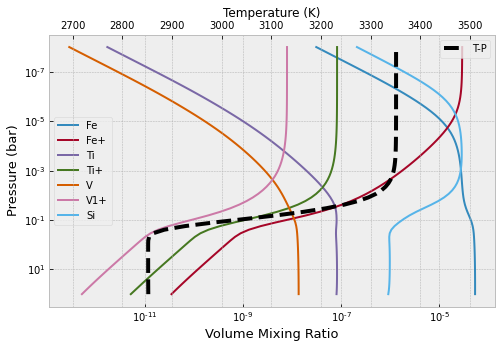

<Figure size 432x288 with 0 Axes>

In [15]:
from exojax.atm.fastchem2_call import vmr_species_fc2

species_name=np.array(["Fe","Fe1+","Ti","Ti1+","V","V1+","Si"])
species_label=np.array(["Fe","Fe+","Ti","Ti+","V","V1+","Si"])

plt.figure(figsize=(8,5))
ax=plt.subplot(111)
for label_ind, spec_name in enumerate (species_name):
    ax.plot(vmr_species_fc2(fastchem,mixing_ratios,spec_name),plist,label=species_label[label_ind])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Volume Mixing Ratio",size=13)
ax.set_ylabel("Pressure (bar)",size=13)
plt.legend()

ax2 = ax.twiny()
ax2.plot(tlist,plist,"k--",lw=4,label="T-P")
ax2.set_xlim(tlist[0]-200,tlist[-1]+200)
ax2.set_xlabel("Temperature (K)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()
plt.clf()

Now for the spectral continuum related species

In [16]:
from exojax.atm.fastchem2_call import continuum_vmr_fc2
vmr_continuum=continuum_vmr_fc2(fastchem,mixing_ratios)

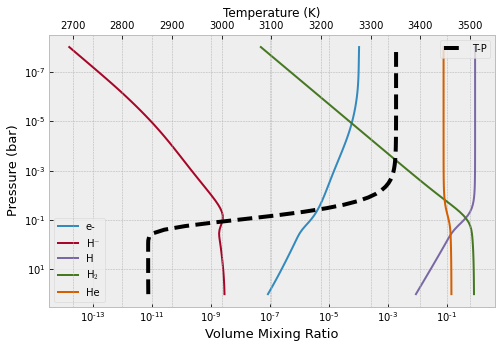

<Figure size 432x288 with 0 Axes>

In [17]:
from exojax.atm.fastchem2_call import vmr_species_fc2

species_label=np.array(["e-","H$^{-}$","H","H$_{2}$","He"])

plt.figure(figsize=(8,5))
ax=plt.subplot(111)
for label_ind, spec_name in enumerate (species_label):
    ax.plot(vmr_continuum[label_ind],plist,label=species_label[label_ind])
    
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Volume Mixing Ratio",size=13)
ax.set_ylabel("Pressure (bar)",size=13)
plt.legend()

ax2 = ax.twiny()
ax2.plot(tlist,plist,"k--",lw=4,label="T-P")
ax2.set_xlim(tlist[0]-200,tlist[-1]+200)
ax2.set_xlabel("Temperature (K)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()
plt.clf()

And the last one is for the mean molecular weight

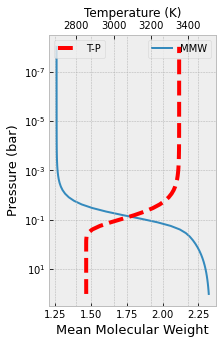

<Figure size 432x288 with 0 Axes>

In [18]:
from exojax.atm.fastchem2_call import vmr_species_fc2

MMW=output_data.mean_molecular_weight

plt.figure(figsize=(3,5))
ax=plt.subplot(111)
ax.plot(MMW,plist,label="MMW")
ax.set_yscale("log")
ax.set_xlabel("Mean Molecular Weight",size=13)
ax.set_ylabel("Pressure (bar)",size=13)
plt.legend()

ax2 = ax.twiny()
ax2.plot(tlist,plist,"r--",lw=4,label="T-P")
ax2.set_xlim(tlist[0]-200,tlist[-1]+200)
ax2.set_xlabel("Temperature (K)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()
plt.clf()